### Figure 8 in Stan and Mantripragada (2023)

The code calculates the MJO filtered anomalies based on Lybarger and Stan (2019)

1. MJO is reconstructed by projecting the PCs onto the daily unfiltered anomalies 
2. MJO is reconstructed by projecting the PCs onto the daily 30-90-day Lanczos filtered anomalies
2. MJO is reconstructed by projecting the PCs onto the daily 30-90-day CNN filtered anomalies

Next, we calculate the Index of Agreement.

The objective is to compare the IOA of above two MJO fields against the MJO that is estimated by projecting the PCs onto the daily 30-90-day Lanczos filtered anomalies.

Input:

1. Surface zonal wind stress anomalies (blended.taux.anom.nc)
2. EOFs ('scat.tauxmjoeof.nc)
3. CNN filter Kernel (90 and 30) weights (taux.filter1.txt and taux.filter1.txt)
4. MJO surface zonal wind stress anomalies that are estimated by projecting the 
   PCs on to lanczos filtered 30-90-day anomlaies (blended.taux.mjo.nc)

Output:

Figure 8 in Stan and Mantripragada (2023)

In [1]:
import xarray as xr
import numpy as np
import proplot as pplt
import copy

In [2]:
################### Load daily zonal wind stress anomalies and their EOFs ############################

inDir = '/scratch/nlybarge/data/'

inDir1 = '/scratch/rmantrip/windstress/'
inDir3 = '/scratch/nlybarge/data/hindcasts/'

inF1 = inDir1+'blended.taux.anom.nc'
inF3 = inDir3+'scat.tauxmjoeof.nc'

ds1 = xr.open_dataset(inF1)
ds3 = xr.open_dataset(inF3)

tauxa = ds1.taux
taux_eof = ds3.taux

nlat = ds1.taux.lat.shape[0]
nlon = ds1.taux.lon.shape[0]
ntime = ds1.taux.time.shape[0]

########################### Load CNN filter weights ############################
### The weights are for 30S to 30N and 125E to 270E
cnnDir1 = '/scratch/rmantrip/CNN/modelweights/windstress/observations/taux/obs_grid/'

taux_filt1 = np.loadtxt(cnnDir1+'taux.filter1.txt', delimiter=',') ## Kernel size 90
taux_filt2 = np.loadtxt(cnnDir1+'taux.filter2.txt', delimiter=',') ## Kernel size 30


# Load the MJO surface zonal wind stress anomalies that are estimated by projecting 
# the PCs on to lanczos filtered 30-90-day anomlaies
# This is already computed and obtained from Lybarger and Stan study

tauxmjo_obs = xr.open_dataset(inDir1+'blended.taux.mjo.nc').taux

In [3]:
############################ Reshape the 3D data to 2D data by stacking lat and lon. Select only non nan values ############################

tauxa_rg = tauxa.transpose('lon','lat','time').stack(grid=("lon","lat")).transpose("grid","time")
indx1 = np.squeeze(np.argwhere(~np.isnan(tauxa_rg[:,10].data))) 
tauxanom = tauxa_rg[indx1,:]

In [4]:
############################ Extracting the Intra-seasonal anomlaies from daily anomlaies using CNN time filter

############### 30-90-day Zonal Wind stress ################

tauxbpf = copy.deepcopy(tauxanom)
for i in range(taux_filt1.shape[1]):
    LowPass = np.convolve(tauxanom[i,:],taux_filt1[:,i],mode='same')
    HighPass = tauxanom[i,:] - LowPass
    tauxbpf[i,:] = np.convolve(HighPass,taux_filt2[:,i],mode='same')

In [5]:
########### Observational based normalized values of PCs ###################
########### Lybarger and Stan used these values to normalize the PCs when calculating MJO fields based on anomlaies ############

xx = [3.5260324e-05,3.8564031e-05,3.9928207e-05,4.1496969e-05]

In [6]:
############ Reshape the 3D EOFs to 2D by stacking lat and lon. Select only non nan values  ############

taux_eof_rg = taux_eof.transpose('lon','lat','ens').stack(grid=("lon","lat")).transpose("grid","ens")
unx = taux_eof_rg[indx1,:]
del taux_eof_rg

In [7]:
############################ Projecting PCs on to the EOFs to reconstruct the MJO wind stress fields ##########################


################### Projecting on daily zonal wind stress intraseasonal anomalies (extracted using CNN filter) ##############

pct = (unx.T.data@tauxbpf.data)/tauxbpf.shape[0]
pc = pct.T

tauxMJO = np.zeros(tauxbpf.shape)

for j in range(4):   
    r = np.matmul(tauxbpf.data,pc[:,j])
    r = r/xx[j]
    tt = np.expand_dims(r,1) * np.expand_dims(pct[j,:],0)     
    tauxMJO = tauxMJO + tt
    
tauxmjo_cnn_rg = copy.deepcopy(tauxa_rg)
tauxmjo_cnn_rg[indx1,:] = tauxMJO
tauxmjo_cnn = tauxmjo_cnn_rg.unstack()

del tauxmjo_cnn_rg,tauxMJO,tt,r,pc,pct

################### Projecting on daily zonal wind stress anomalies ##############

pct = (unx.T.data@tauxanom.data)/tauxanom.shape[0]
pc = pct.T

tauxMJO = np.zeros(tauxanom.shape)

for j in range(4):   
    r = np.matmul(tauxanom.data,pc[:,j])
    r = r/xx[j]
    tt = np.expand_dims(r,1) * np.expand_dims(pct[j,:],0)     
    tauxMJO = tauxMJO + tt


tauxmjo_anom_rg = copy.deepcopy(tauxa_rg)
tauxmjo_anom_rg[indx1,:] = tauxMJO
tauxmjo_anom = tauxmjo_anom_rg.unstack()

del tauxmjo_anom_rg,tauxMJO,tt,r,pc,pct,unx


tauxmjo_anom = tauxmjo_anom.transpose('time','lat','lon')
tauxmjo_cnn = tauxmjo_cnn.transpose('time','lat','lon')



In [8]:
# Latitudinal average of MJO surface zonal wind stress anomalies
tauxmjo_anom_lon = tauxmjo_anom.sel(lat=slice(-7.5,7.5),lon=slice(155,265)).mean('lat',skipna=True).interpolate_na('lon')
tauxmjo_cnn_lon = tauxmjo_cnn.sel(lat=slice(-7.5,7.5),lon=slice(155,265)).mean('lat',skipna=True).interpolate_na('lon')
tauxmjo_obs_lon = tauxmjo_obs.sel(lat=slice(-7.5,7.5),lon=slice(155,265)).mean('lat',skipna=True).interpolate_na('lon')

In [9]:
def index_agreement(s, o):
    ia = 1 -(np.sum((o-s)**2))/(np.sum(
            (np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [10]:
nyr = 29
nlon = tauxmjo_obs_lon.lon.shape[0]
ioa_anom = np.zeros((nyr,nlon))
ioa_cnn = np.zeros((nyr,nlon))

i = 0
for year in range(1988,2017):
    
    ex1anom = tauxmjo_anom_lon.sel(time=str(year))
    ex1cnn = tauxmjo_cnn_lon.sel(time=str(year))
    ex1obs = tauxmjo_obs_lon.sel(time=str(year))
    
    for j in range(nlon):
        
        ioa_anom[i,j] = index_agreement(ex1obs[:,j],ex1anom[:,j])
        ioa_cnn[i,j] = index_agreement(ex1obs[:,j],ex1cnn[:,j])
      
    del ex1anom,ex1obs,ex1cnn 
        
    i = i + 1

In [11]:

ioa_anom = xr.DataArray(ioa_anom, dims=['year','lon'])
ioa_anom['year'] = np.arange(1988,2017,1)
ioa_anom['lon'] = tauxmjo_obs_lon.lon

ioa_cnn = xr.DataArray(ioa_cnn, dims=['year','lon'])
ioa_cnn['year'] = np.arange(1988,2017,1)
ioa_cnn['lon'] = tauxmjo_obs_lon.lon


In [12]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':36,'titlesize':38})

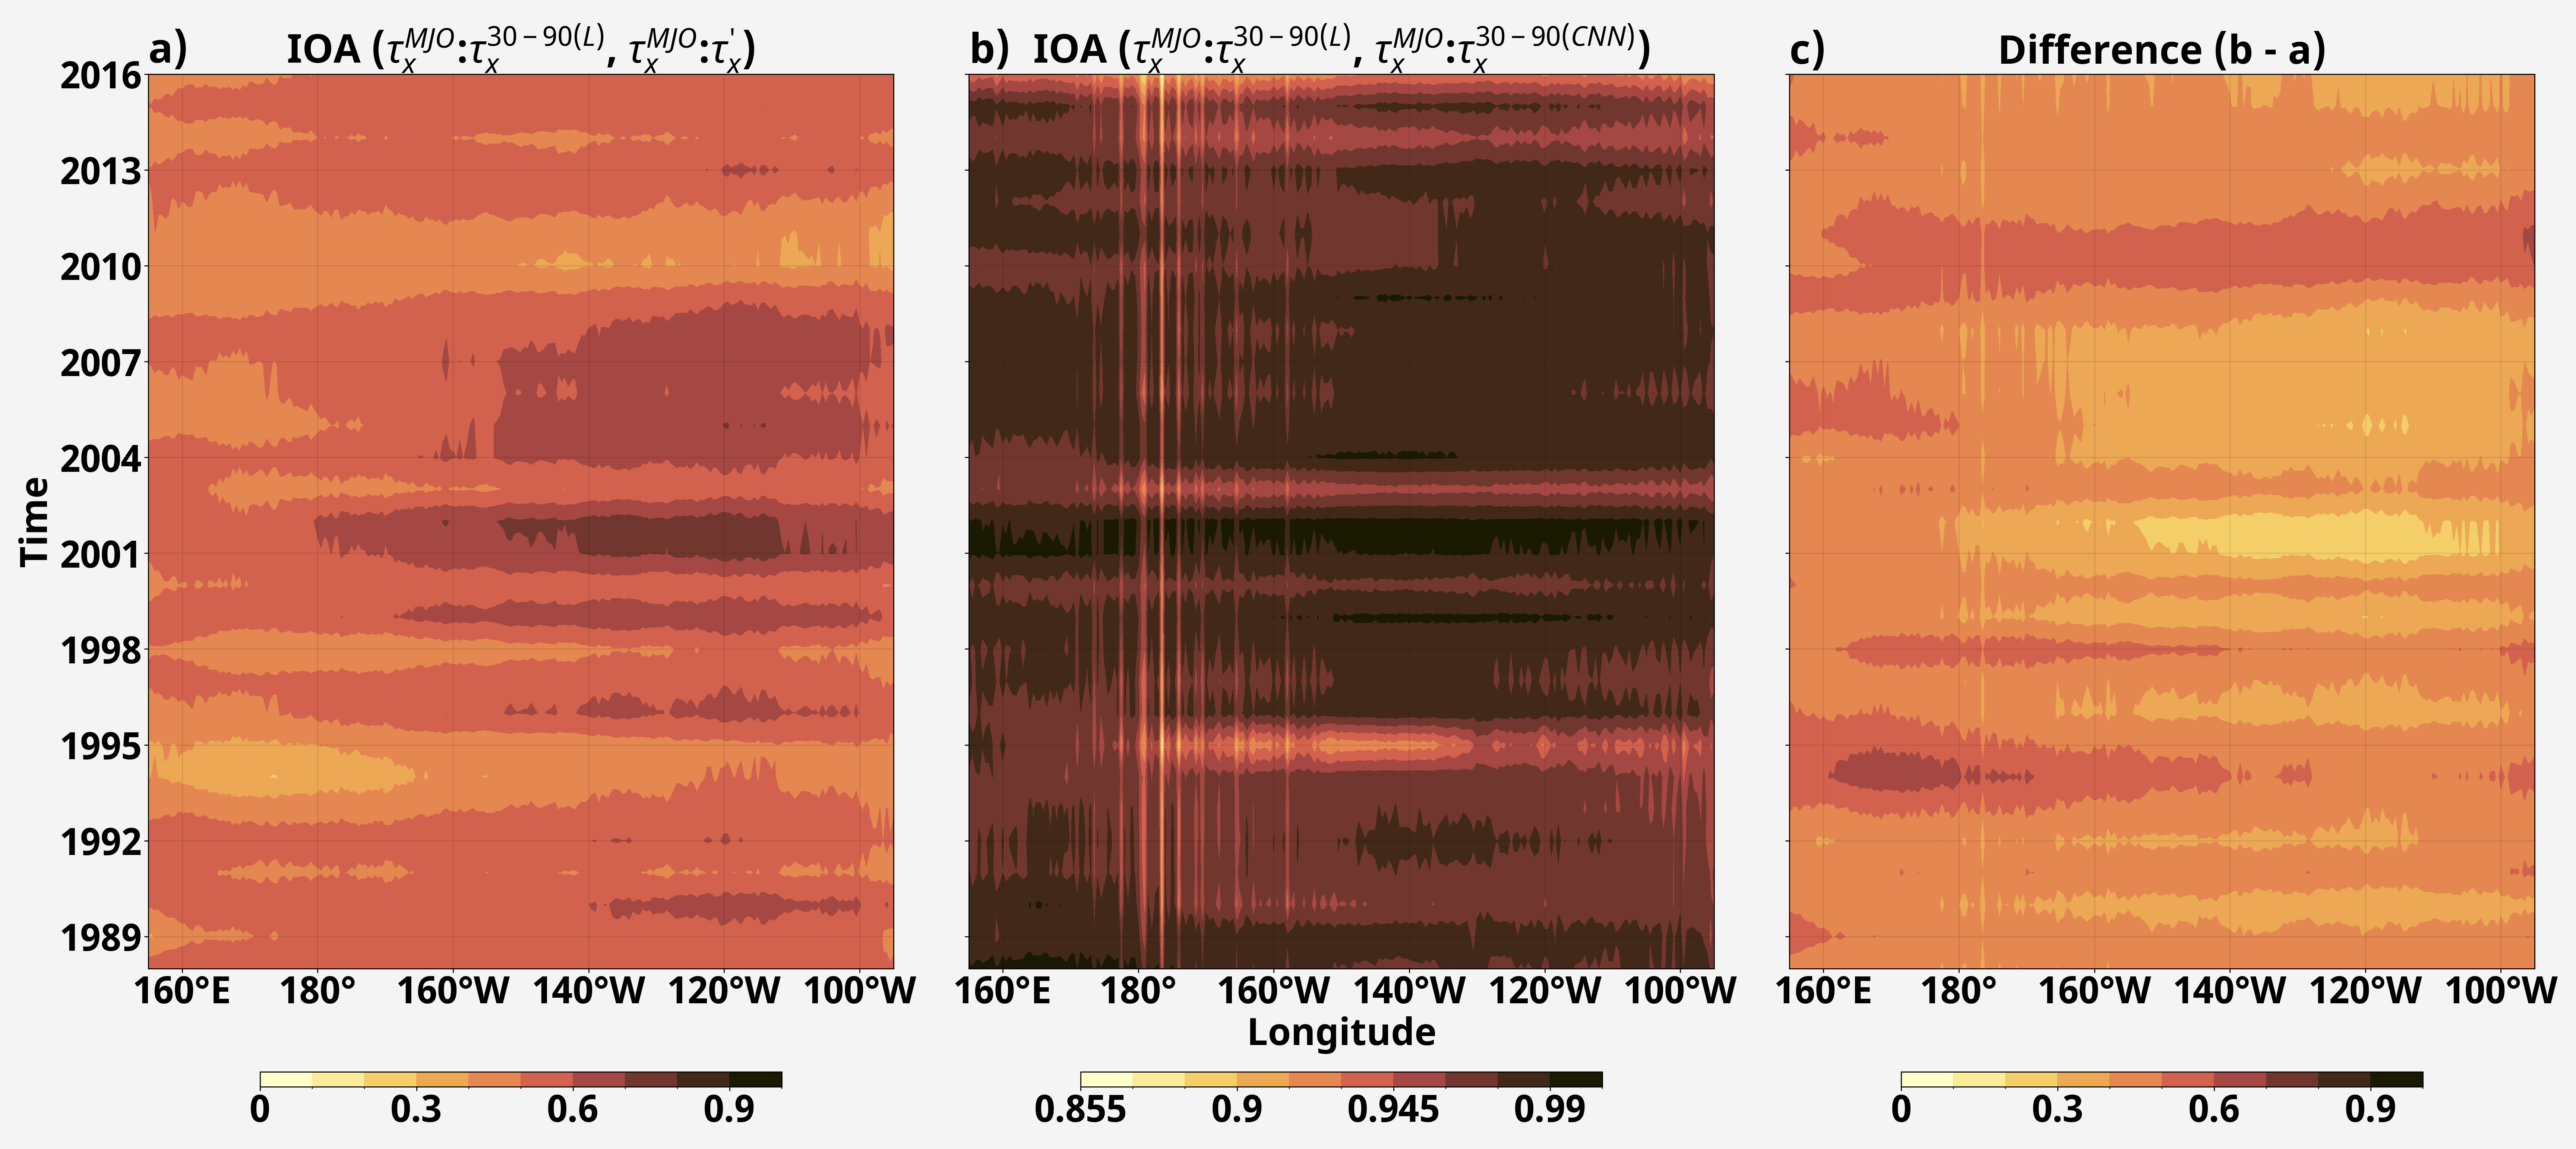

In [13]:
fig, axs = pplt.subplots(nrows=1,ncols=3,refwidth=10,refheight=12)#,refheight=22)

axs.format(xlabel='',ylabel='',xformatter='deglon',ylocator=3,xlocator=20,xtickminor=False,ytickminor=False,abc='a)',abcloc='l')


levels1 = np.arange(0,1.1,.1)
levels2 = np.arange(.9,1.01,.01)

im1 = axs[0].contourf(ioa_anom,cmap='lajolla',levels=levels1,extend='neither',colorbar=False)
im2 = axs[1].contourf(ioa_cnn,cmap='lajolla',vmin=ioa_cnn.min().values,extend='neither',colorbar=False)
axs[2].contourf((ioa_cnn - ioa_anom),cmap='lajolla',levels=levels1,extend='neither',colorbar=False)

#axs[0].set_title("IOA between " +r"$\tau_x^{MJO}$ reconstructed using $\tau_x^{30-90(L)}$[$\tau_x^{MJO}$:$\tau_x^{30-90(L)}]$"+"\n"+"and"+"\n"+r"$\tau_x^{MJO}$ reconstructed using $\tau_x'$[$\tau_x^{MJO}$:$\tau_x'$]")
#axs[1].set_title("Difference between "+r"IOA[$\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x^{30-90(CNN)}$]"+"\n"+"and"+"\n"+r"IOA[$\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x'$]")
axs[0].set_title(r"IOA ($\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x'$)")
axs[1].set_title(r"IOA ($\tau_x^{MJO}$:$\tau_x^{30-90(L)}$, $\tau_x^{MJO}$:$\tau_x^{30-90(CNN)}$)")

axs[2].set_title('Difference (b - a)')
axs[0].colorbar(im1,location='bottom',shrink= 0.7, width= 0.2,label='')
axs[1].colorbar(im2,location='bottom',shrink= 0.7, width= 0.2,label='')
axs[2].colorbar(im1,location='bottom',shrink= 0.7, width= 0.2,label='')
axs.format(xlabel='Longitude',ylabel='Time')
#fig.suptitle('')

fig.savefig('Fig8.png',dpi=150)